In [2]:
import rasterio 
import rasterio.mask
import geopandas as gpd
import fiona
import os
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, savefig, xlim, figure, \
                 ylim, legend, boxplot, setp, axes
import matplotlib.patches as mpatches
import matplotlib as mpl

def mkdir(dir):
    
    if not os.path.exists(dir):
        os.mkdir(dir)
        
path_run = os.getcwd() + '/'
path_data_processed = path_run + 'data_processed/'
path_plots = path_run + 'plots/'
path_plots_creator = mkdir(path_plots)

results = pd.DataFrame()

for filename in sorted(os.listdir(f"{path_data_processed}affected_people/")):
    print(filename)
    results_temp = pd.read_csv(f"{path_data_processed}affected_people/" + filename)
    results = results.append(results_temp)

results_max_100_wind_final.csv
results_max_10_wind_final.csv
results_max_50_wind_final.csv
results_mean_100_wind_final.csv
results_mean_10_wind_final.csv
results_mean_50_wind_final.csv
results_min_100_wind_final.csv
results_min_10_wind_final.csv
results_min_50_wind_final.csv
results_no_100_wind_final.csv
results_no_10_wind_final.csv
results_no_50_wind_final.csv


In [3]:
results['scenario'] = results['scenario'].str.replace('cf','factual')

displacements_IDMC = 478169

def cf_group(x):


        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))          
results_ext = pd.DataFrame()

for tide in ['no','mean','max','min']:
    
    for threshold in [10,50,100]:

        results_temp = results[results['tide']==tide]
        results_temp = results_temp[results_temp['threshold']==threshold]
        factual_temp_value = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp_value - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],4)

        results_temp['cf_group'] = results_temp['scenario'].apply(lambda x: cf_group(x))
        results_temp.loc[:,'affected_flood_wind'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96']
        results_temp.loc[:,'affected_flood_wind_cf'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96_cf']

        factual_temp = results_temp[results_temp['scenario']=='factual']
        factual_temp.loc[:,'displacements'] = displacements_IDMC

        non_factual_temp = results_temp[results_temp['scenario']!='factual']
        results_temp_remerged = factual_temp.append(non_factual_temp)
        results_temp_remerged.loc[:,'vulnerability'] = (factual_temp['displacements']/factual_temp['affected']).iloc[0]
        results_temp_remerged.loc[:,'displacements'] = round(results_temp_remerged['vulnerability']*results_temp_remerged['affected'],0)
        results_temp_remerged.loc[:,'displacements_dif'] = displacements_IDMC - results_temp_remerged['displacements']
        results_temp_remerged.loc[:,'displacements_dif_perc'] = np.round(100*results_temp_remerged['displacements_dif']/results_temp_remerged['displacements'],4)
        
        results_temp_remerged.loc[:,'vulnerability_flood_wind'] = (factual_temp['displacements']/factual_temp['affected_flood_wind']).iloc[0]
        results_temp_remerged.loc[:,'displacements_flood_wind_cf'] = round(results_temp_remerged['affected_flood_wind_cf'] * results_temp_remerged['vulnerability_flood_wind'],0)
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif'] = displacements_IDMC - results_temp_remerged['displacements_flood_wind_cf'] 
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif_perc_of_tot_disp'] = np.round(100*results_temp_remerged['displacements_flood_wind_cf_dif']/displacements_IDMC,4)
 
        results_ext = results_ext.append(results_temp_remerged)
        
results_ext.reset_index(inplace=True)                       
results_ext

/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a c

,index,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,factual,no,10,2047946,1143302.0,848656.0,123937.0,0.0,0,...,2171883.0,2047946.0,478169.0,0.233487,0.0,0.0000,0.220163,450883.0,27286.0,5.7064
1,1,factualwind,no,10,1786714,1334355.0,1039461.0,310520.0,0.0,2,...,2097234.0,1786714.0,417175.0,0.233487,60994.0,14.6207,0.220163,393369.0,84800.0,17.7343
2,2,factualwindzos065,no,10,1768112,1343009.0,1047986.0,318753.0,0.0,3,...,2086865.0,1768112.0,412831.0,0.233487,65338.0,15.8268,0.220163,389273.0,88896.0,18.5909
3,3,factualwindzos070,no,10,1766787,1343011.0,1047988.0,318753.0,0.0,3,...,2085540.0,1766787.0,412522.0,0.233487,65647.0,15.9136,0.220163,388982.0,89187.0,18.6518
4,4,factualwindzos075,no,10,1766787,1343011.0,1047988.0,318753.0,0.0,3,...,2085540.0,1766787.0,412522.0,0.233487,65647.0,15.9136,0.220163,388982.0,89187.0,18.6518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,41,factualzos150,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
548,42,factualzos155,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
549,43,factualzos160,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
550,44,factualzos165,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564


In [4]:
results_ext.to_csv(path_data_processed + 'all_results.csv')

In [5]:
#flooding

print('flooding \n')

results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print('Median % change for max:',round(np.median(results_ext_temp['affected_dif_perc']),1))
print('Max. change in displacements for max:',round(np.max(results_ext_temp['displacements_dif']),-2))
# print('Median change in affected for max:',round(np.median(results_ext_temp['affected_dif']),-2))
print('Max. change in affected for max:',round(np.max(results_ext_temp['affected_dif']),-2),'\n')

results_ext_temp = results_ext[results_ext['tide']=='no']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]


print('Median % change for no:',round(np.median(results_ext_temp['affected_dif_perc']),1))
print('Max. change in displacements for no:',round(np.max(results_ext_temp['displacements_dif']),-2))
# print('Median change in affected for no:',round(np.median(results_ext_temp['affected_dif']),-2))
print('Max. change in affected for no:',round(np.max(results_ext_temp['affected_dif']),-2),'\n')

# all depth thresholds

print('All depth thresholds \n')

results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print('Max overall change in displacements:', round(np.max(results_ext.sort_values('displacements_dif',ascending=False)['displacements_dif']),-2))                                                  
print('Max overall change in %:',round(np.max(results_ext.sort_values('displacements_dif_perc',ascending=False)['displacements_dif_perc']),1),'\n')                                                
                              
    
# wind

print('wind - max tide \n')
results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print("min number of affected:",round(np.min(results_ext_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2))
print("max number of affected:",round(np.max(results_ext_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2),'\n')

print('min number of displacements:',round(np.min(results_ext_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2))
print('max number of displacements:',round(np.max(results_ext_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2),'\n')


print("min % of all displacements:",round(np.min(results_ext_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1))
print("max % of all displacements:",round(np.max(results_ext_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1),'\n')

flooding 

Median % change for max: 3.1
Max. change in displacements for max: 16500.0
Max. change in affected for max: 43300 

Median % change for no: 3.5
Max. change in displacements for no: 17100.0
Max. change in affected for no: 44300 

All depth thresholds 

Max overall change in displacements: 69800.0
Max overall change in %: 17.1 

wind - max tide 

min number of affected: 354400.0
max number of affected: 357400.0 

min number of displacements: 109200.0
max number of displacements: 111500.0 

min % of all displacements: 22.8
max % of all displacements: 23.3 



# Plot

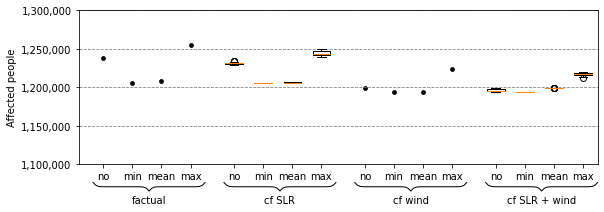

In [6]:
# Affected people - 100 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(3)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==0]
        results_temp_list.append(list(results_temp_cf_group['affected']))
        
    plt.scatter([0,1,2,3],results_temp_list,color='black',s=14)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_2 = boxplot(results_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    plt.scatter([9,10,11,12],results_temp_list,color='black',s=14)
    
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_3 = boxplot(results_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.01*yspan, text, ha='center', va='bottom')
    dif = -1061000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_100_000,1_300_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

fig.tight_layout()

fig.savefig(f"{path_plots}/plot_all_tides_affected_people_100.png",dpi=300)

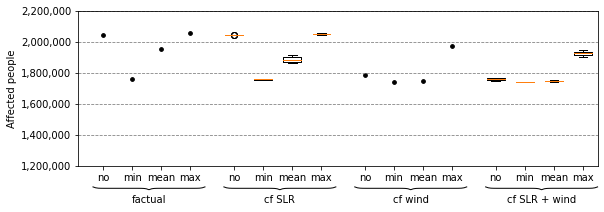

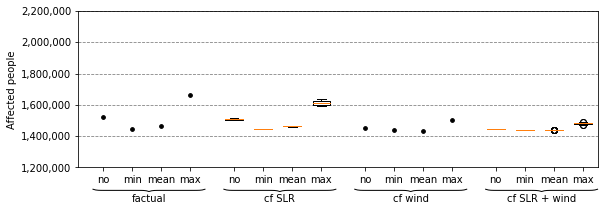

In [7]:
# Affected people - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

threshold_counter = 0

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)

    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==0]
        results_temp_list.append(list(results_temp_cf_group['affected']))
    
    plt.scatter([0,1,2,3],results_temp_list,color='black',s=14)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_2 = boxplot(results_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    plt.scatter([9,10,11,12],results_temp_list,color='black',s=14)
    
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_3 = boxplot(results_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.04*yspan, text, ha='center', va='bottom')
    dif = -1040000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_200_000,2_200_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_{threshold}.png",dpi=300)

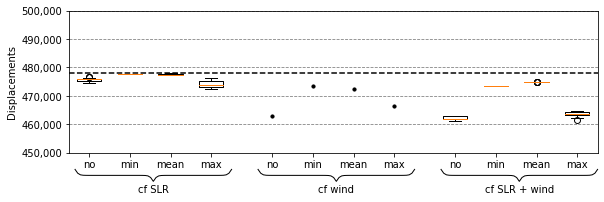

In [10]:
# Displacements - 100 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [100]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)

    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=10)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.011*yspan, text, ha='center', va='bottom')
        
    dif = -441000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(450_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')
    
    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

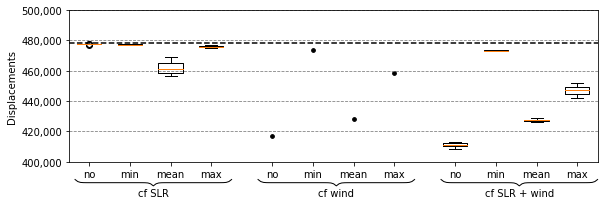

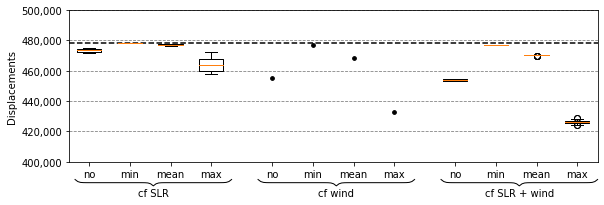

In [11]:
# Displacements - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [10,50]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]
        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=14)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')

    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.017*yspan, text, ha='center', va='bottom')
        
    dif = -385000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(400_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

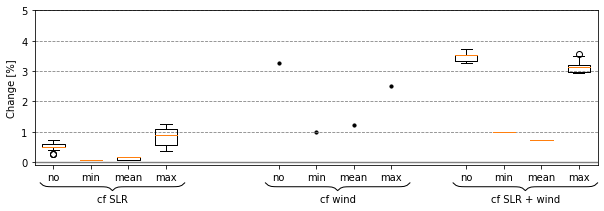

In [8]:
# Change affected people - 100 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)


    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)

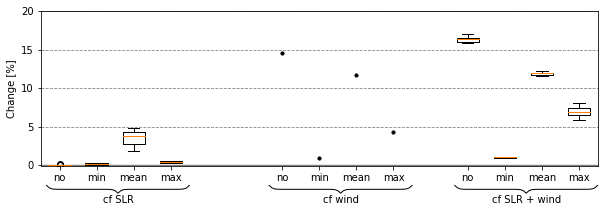

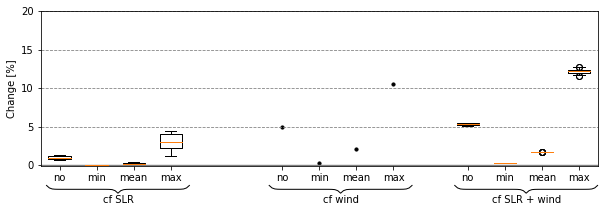

In [9]:
# Change affected people - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,20)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .05)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
    dif = 1.1
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),dif, 'cf wind')
    draw_brace(ax1, (10.65,14.5),dif, 'cf SLR + wind')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_{threshold}.png",dpi=300)